In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
from IPython import display

In [2]:
#np.random.seed(96)

In [3]:
%run modules.ipynb

In [4]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

In [5]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [6]:
# Preprocess the data
x_train, y_train = loadlocal_mnist(
        images_path='../Data/train-images-idx3-ubyte', 
        labels_path='../Data/train-labels-idx1-ubyte')
x_test, y_test = loadlocal_mnist(
        images_path='../Data/t10k-images-idx3-ubyte',
        labels_path='../Data/t10k-labels-idx1-ubyte')

# define dataset metadata
n_train_samples = y_train.shape[0]
n_test_samples = y_test.shape[0]
n_features = x_train.shape[1]
n_classes = y_train.max() + 1

# normalize
x_train = x_train.astype(float) / 255.0
x_test = x_test.astype(float) / 255.0

# make onehot
y_train_oh = np.zeros((y_train.shape[0], n_classes), dtype=float)
y_test_oh = np.zeros((y_test.shape[0], n_classes), dtype=float)
for i in range(n_train_samples):
    y_train_oh[i][y_train[i]] = 1.0
for i in range(n_test_samples):
    y_test_oh[i][y_test[i]] = 1.0


In [7]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 200

In [8]:
net = Sequential()
net.add(Linear(x_train.shape[1], 400))
net.add(ReLU())
net.add(Dropout(0.8))
net.add(Linear(400, 100))
net.add(Sigmoid())
net.add(Linear(100, 10))
net.add(SoftMax())

criterion = MSECriterion()

print(net)

Linear 784 -> 400
ReLU
Dropout
Linear 400 -> 100
Sigmoid
Linear 100 -> 10
SoftMax



In [9]:
# Training and testing
train_loss_history = []
test_loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train_oh), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        train_loss_history.append(loss)
    
    # Test
    test_pred = net.forward(x_test)
    test_loss = criterion.forward(test_pred, y_test_oh)
    test_loss_history.append(test_loss)

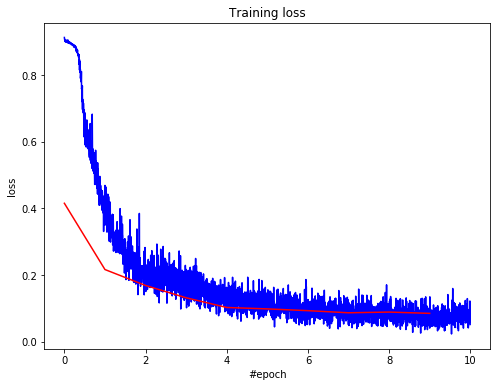

Current train loss: 0.051397
Current test loss: 0.084764


In [10]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
epoch_ticks = np.arange(0, len(train_loss_history), dtype=float) / (n_train_samples // batch_size)
plt.plot(epoch_ticks, train_loss_history, 'b')
plt.plot(test_loss_history, 'r')

plt.show()

print('Current train loss: %f' % loss)
print('Current test loss: %f' % test_loss)